# Load data

In [1]:
!wget -O Data.npz https://zenodo.org/record/4269852/files/dermamnist.npz?download=1

--2021-08-13 12:19:20--  https://zenodo.org/record/4269852/files/dermamnist.npz?download=1
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19725078 (19M) [application/octet-stream]
Saving to: ‘Data.npz’

Data.npz            100%[===================>]  18.81M  8.91MB/s    in 2.1s    

2021-08-13 12:19:23 (8.91 MB/s) - ‘Data.npz’ saved [19725078/19725078]



In [23]:
import matplotlib.pyplot as plt   
import numpy as np
import matplotlib.image as mpimg
import cv2
from tensorflow.keras.utils import to_categorical

In [24]:
d = np.load('Data.npz')
print(d.files)

['train_images', 'val_images', 'test_images', 'train_labels', 'val_labels', 'test_labels']


In [25]:
print(d['train_labels'].shape)

(7007, 1)


Train: X=(7007, 28, 28, 3), y=(7007, 1)
Test: X=(2005, 28, 28, 3), y=(2005, 1)


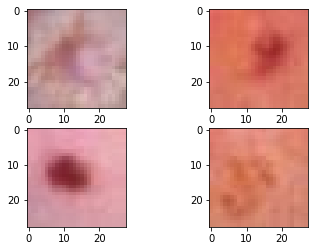

In [26]:
print('Train: X=%s, y=%s' % (d['train_images'].shape, d['train_labels'].shape))
print('Test: X=%s, y=%s' % (d['test_images'].shape, d['test_labels'].shape))
# plot some images
for i in range(4):
	plt.subplot(220 + 1 + i)
	plt.imshow(d['train_images'][i])
plt.show()

In [27]:
data = {key: d[key] for key in d.files}

In [28]:
data['train_images'][0].shape

(28, 28, 3)

# Preprocessing

In [29]:
# Display one image
def display_one(a, title1 = "Original"):
    plt.imshow(a), plt.title(title1)
    plt.xticks([]), plt.yticks([])
    plt.show()

# Display two images
def display(a, b, title1 = "Original", title2 = "Edited"):
    plt.subplot(121), plt.imshow(a), plt.title(title1)
    plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(b), plt.title(title2)
    plt.xticks([]), plt.yticks([])
    plt.show()

## Resize Images
## Remove noise(Denoise)


In [30]:
# resize images
def resize_image(data):
    img = data
    print(len(img))
    print('Original size',img[0].shape)
    # setting dim of the resize
    height = 64
    width = 64
    dim = (width, height)
    res_img = []
    for i in range(len(img)):
        res = cv2.resize(img[i], dim, interpolation=cv2.INTER_LINEAR)
        res_img.append(res)

    # Checcking the size
    print("RESIZED", res_img[0].shape)
    
    # Visualizing one of the images in the array
    original = res_img[0]
    display_one(original)

    # Remove noise
    # Gaussian
    no_noise = []
    for i in range(len(res_img)):
      blur = cv2.GaussianBlur(res_img[i], (5, 5), 0)
      no_noise.append(blur)

    image = no_noise[0]
    display(original, image, 'Original', 'Blured')

    return np.array(no_noise)

7007
Original size (28, 28, 3)
RESIZED (64, 64, 3)


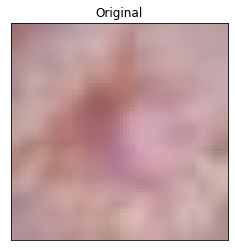

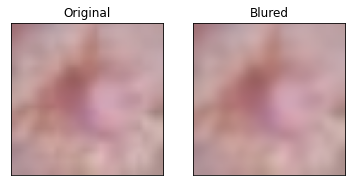

1003
Original size (28, 28, 3)
RESIZED (64, 64, 3)


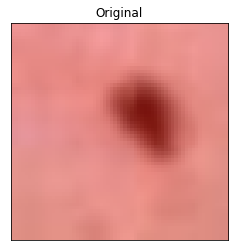

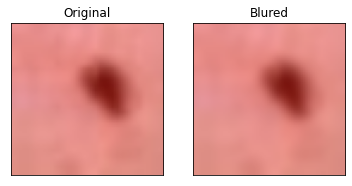

2005
Original size (28, 28, 3)
RESIZED (64, 64, 3)


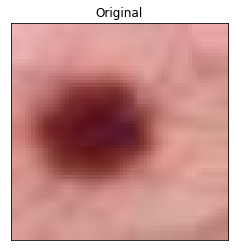

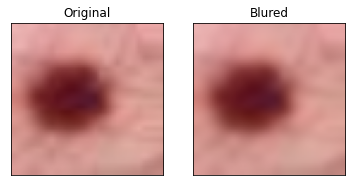

In [31]:
# Resize all images
data = dict({key: resize_image(data[key]) for key in d.files[:3]}, **{key: data[key] for key in d.files[3:]})

In [32]:
data['val_images'][6].shape

(64, 64, 3)

In [33]:
for tag in list(data.keys())[:3]:
  # convert from integers to floats
  data[tag] = data[tag].astype('float32')
  # normalize to range 0-1
  data[tag] /= 255

# one hot y values
for tag in list(data.keys())[3:]:
  data[tag] = to_categorical(data[tag])

In [34]:
data['test_images'].shape

(2005, 64, 64, 3)

# VGG Model

In [35]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets.cifar10 import load_data

In [51]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=data['train_images'][0].shape, kernel_regularizer=l2(0.001)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model.add(MaxPool2D((2, 2), strides=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model.add(MaxPool2D((2, 2), strides=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model.add(MaxPool2D((2, 2), strides=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))
model.add(Dense(7, activation='softmax'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 16, 16, 64)       

In [52]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['acc'])

In [53]:
data['val_labels'][0]

array([0., 0., 0., 0., 0., 1., 0.], dtype=float32)

In [54]:
history = model.fit(data['train_images'], data['train_labels'], batch_size=32, epochs=20, validation_data=(data['val_images'], data['val_labels']))

Epoch 1/20
219/219 [==============================] - 5s 16ms/step - loss: 1.3548 - acc: 0.6665 - val_loss: 1.1278 - val_acc: 0.6690
Epoch 2/20
219/219 [==============================] - 3s 13ms/step - loss: 1.0833 - acc: 0.6698 - val_loss: 1.0834 - val_acc: 0.6690
Epoch 3/20
219/219 [==============================] - 3s 13ms/step - loss: 1.0313 - acc: 0.6695 - val_loss: 1.0284 - val_acc: 0.6750
Epoch 4/20
219/219 [==============================] - 3s 13ms/step - loss: 1.0009 - acc: 0.6718 - val_loss: 0.9834 - val_acc: 0.6690
Epoch 5/20
219/219 [==============================] - 3s 13ms/step - loss: 0.9837 - acc: 0.6733 - val_loss: 0.9521 - val_acc: 0.6750
Epoch 6/20
219/219 [==============================] - 3s 13ms/step - loss: 0.9627 - acc: 0.6803 - val_loss: 0.9388 - val_acc: 0.6770
Epoch 7/20
219/219 [==============================] - 3s 13ms/step - loss: 0.9480 - acc: 0.6807 - val_loss: 0.9634 - val_acc: 0.6730
Epoch 8/20
219/219 [==============================] - 3s 13ms/step - 

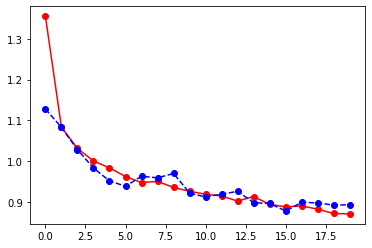

In [55]:
plt.plot(history.history['loss'], 'r-o')
plt.plot(history.history['val_loss'], 'b--o')

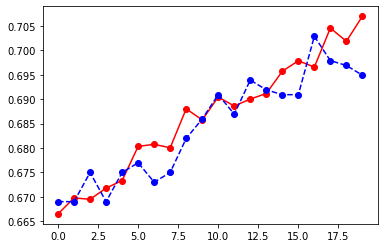

In [56]:
plt.plot(history.history['acc'], 'r-o')
plt.plot(history.history['val_acc'], 'b--o')

In [57]:
model.evaluate(data['test_images'], data['test_labels'])

63/63 [==============================] - 1s 9ms/step - loss: 0.8823 - acc: 0.6968


[0.8822916150093079, 0.6967580914497375]